In [1]:
import numpy as np
import dolfin as dl
from ufl import lhs, rhs, replace
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.linalg as sla
import matplotlib.pyplot as plt
from pathlib import Path
from nalger_helper_functions import *
import meshio
import scipy.io as sio
from scipy.spatial import KDTree as scipy_KDTree
from localpsf import localpsf_root
from nalger_helper_functions import *

from localpsf.derivatives_at_point import StokesDerivativesAtPoint
from localpsf.bilaplacian_regularization import BiLaplacianRegularization

# Options

In [2]:
mesh_type = 'fine'
noise_level=1e-2
relative_prior_correlation_length=0.1
save_plots=True
gamma=1e4 # regularization gamma
m0_constant_value = 1.5 * 7.
rel_correlation_length = 0.1
reg_robin_bc=True
mtrue_type = 'angel_peak'
mtrue_string = 'm0 - (m0 / 7.)*std::cos(2.*x[0]*pi/Radius)'
solver_type = 'mumps'
outflow_constant = 1.0e6
gamma_morozov = 7285.488266896614

# Mesh

## Load unmodified mesh

In [3]:
if mesh_type == 'coarse':
    mfile_name = str(localpsf_root) + "/numerical_examples/stokes/meshes/cylinder_coarse"
    lam = 1e10
elif mesh_type == 'medium':
    mfile_name = str(localpsf_root) + "/numerical_examples/stokes/meshes/cylinder_medium"
    lam = 1e11
elif mesh_type == 'fine':
    mfile_name = str(localpsf_root) + "/numerical_examples/stokes/meshes/cylinder_fine"
    lam = 1e12
else:
    raise RuntimeError('invalid mesh type '+mesh_type+', valid types are coarse, medium, fine')
    
mesh = dl.Mesh(mfile_name+".xml")

mesh

## Boundary submeshes and subdomains

In [4]:
class BasalBoundary(dl.SubDomain):
    def inside(me, x, on_boundary):
        return dl.near(x[2], 0.) and on_boundary

class BasalBoundarySub(dl.SubDomain):
    def inside(me, x, on_boundary):
        return dl.near(x[2], 0.)

class TopBoundary(dl.SubDomain):
    def __init__(me, Height):
        me.Height = Height
        dl.SubDomain.__init__(me)
    def inside(me, x, on_boundary):
        return dl.near(x[1], me.Height) and on_boundary
    
boundary_markers = dl.MeshFunction("size_t", mesh, mfile_name+"_facet_region.xml")
boundary_mesh = dl.BoundaryMesh(mesh, "exterior", True)
basal_mesh3D = dl.SubMesh(boundary_mesh, BasalBoundarySub())

basal_mesh3D

## Modify mesh

In [5]:
r0 = 0.05
sig = 0.4
valleys = 4
valley_depth = 0.35
bump_height = 0.2
min_thickness = 0.08 / 8.
avg_thickness = 0.2 / 8.
theta = -np.pi / 2.
max_thickness = avg_thickness + (avg_thickness - min_thickness)
A_thickness = max_thickness - avg_thickness

dilitation = 1.e4
Length = 1.
Width = 1.
Length *= 2 * dilitation
Width *= 2 * dilitation
Radius = dilitation

prior_correlation_length = relative_prior_correlation_length * Radius

coords = mesh.coordinates()
bcoords = boundary_mesh.coordinates()
subbcoords = basal_mesh3D.coordinates()
coord_sets = [coords, bcoords, subbcoords]

def topography(r, t):
    zero = np.zeros(r.shape)
    R0 = r0 * np.ones(r.shape)
    return bump_height * np.exp(-(r / sig) ** 2) * (
                1. + valley_depth * np.sin(valleys * t - theta) * np.fmax(zero, (r - R0) / sig))

def depth(r, t):
    zero = np.zeros(r.shape)
    R0 = r0 * np.ones(r.shape)
    return min_thickness - A_thickness * np.sin(valleys * t - theta) * np.exp(
        -(r / sig) ** 2) * np.fmax(zero, (r - R0) / sig)

for k in range(len(coord_sets)):
    for i in range(len(coord_sets[k])):
        x, y, z = coord_sets[k][i]
        r = np.sqrt(x ** 2 + y ** 2)
        t = np.arctan2(y, x)
        coord_sets[k][i, 2] = depth(r, t) * z + topography(r, t)
        coord_sets[k][i] *= dilitation
        
mesh

In [6]:
basal_mesh3D

## 2D Basal mesh

Text(0.5, 1.0, '2D Basal Mesh')

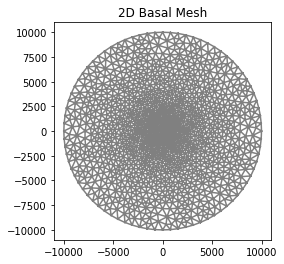

In [7]:
# ------ generate 2D mesh from 3D boundary subset mesh
coords = basal_mesh3D.coordinates()[:, :2]
cells = [("triangle", basal_mesh3D.cells())]
mesh2D = meshio.Mesh(coords, cells)
mesh2D.write("mesh2D.xml")
basal_mesh2D = dl.Mesh("mesh2D.xml")

np.savetxt('mesh_vertices.txt', basal_mesh2D.coordinates())
np.savetxt('mesh_cells.txt', basal_mesh2D.cells(), fmt='%i')

dl.plot(basal_mesh2D)
plt.title('2D Basal Mesh')

# Plots to make (1): 
 - 3D mesh, colors, light mesh edges
 - 2D mesh top-view, edges only, black and white

# Function spaces

In [8]:
P1 = dl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
P2 = dl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
TH = P2 * P1

Zh = dl.FunctionSpace(mesh, TH)                     # Zh:  state, also adjoint
Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)          # Wh:  parameter, full 3D domain
Vh3 = dl.FunctionSpace(basal_mesh3D, 'Lagrange', 1) # Vh3: parameter, 2d basal manifold, 3d coords
Vh2 = dl.FunctionSpace(basal_mesh2D, 'Lagrange', 1) # Vh2: parameter, 2d basal flat space, 2d coords
Xh = [Zh, Wh, Zh]                                   # Xh:  (state, parameter full 3D domain, adjoint)

## Transfer operators between function spaces

In [9]:
def function_space_prolongate_numpy(x_numpy, dim_Yh, inds_Xh_in_Yh):
    y_numpy = np.zeros(dim_Yh)
    y_numpy[inds_Xh_in_Yh] = x_numpy
    return y_numpy

def function_space_restrict_numpy(y_numpy, inds_Xh_in_Yh):
    return y_numpy[inds_Xh_in_Yh].copy()

def function_space_prolongate_petsc(x_petsc, Yh, inds_Xh_in_Yh):
    y_petsc = dl.Function(Yh).vector()
    y_petsc[:] = function_space_prolongate_numpy(x_petsc[:], Yh.dim(), inds_Xh_in_Yh)
    return y_petsc

def function_space_restrict_petsc(y_petsc, Xh, inds_Xh_in_Yh):
    x_petsc = dl.Function(Xh).vector()
    x_petsc[:] = function_space_restrict_numpy(y_petsc[:], inds_Xh_in_Yh)
    return x_petsc

def make_prolongation_and_restriction_operators(Vsmall, Vbig, inds_Vsmall_in_Vbig):
    Vbig_to_Vsmall_numpy = lambda vb: function_space_restrict_numpy(vb, inds_Vsmall_in_Vbig)
    Vsmall_to_Vbig_numpy = lambda vs: function_space_prolongate_numpy(vs, Vbig.dim(), inds_Vsmall_in_Vbig)

    Vbig_to_Vsmall_petsc = lambda vb: function_space_restrict_petsc(vb, Vsmall, inds_Vsmall_in_Vbig)
    Vsmall_to_Vbig_petsc = lambda vs: function_space_prolongate_petsc(vs, Vbig, inds_Vsmall_in_Vbig)

    return Vbig_to_Vsmall_numpy, Vsmall_to_Vbig_numpy, Vbig_to_Vsmall_petsc, Vsmall_to_Vbig_petsc

In [10]:
pp_Vh3 = Vh3.tabulate_dof_coordinates()
pp_Vh2 = Vh2.tabulate_dof_coordinates()
pp_Wh = Wh.tabulate_dof_coordinates()

KDT_Wh = scipy_KDTree(pp_Wh)
inds_Vh3_in_Wh = KDT_Wh.query(pp_Vh3)[1]
if np.linalg.norm(pp_Vh3 - pp_Wh[inds_Vh3_in_Wh, :]) / np.linalg.norm(pp_Vh3) > 1.e-12:
    warnings.warn('problem with basal function space inclusion')

pp_Vh3_2D = pp_Vh3[:,:2]

KDT_Vh3_2D = scipy_KDTree(pp_Vh3_2D)
inds_Vh2_in_Vh3 = KDT_Vh3_2D.query(pp_Vh2)[1]
if np.linalg.norm(pp_Vh2 - pp_Vh3[inds_Vh2_in_Vh3, :2]) / np.linalg.norm(pp_Vh2) > 1.e-12:
    warnings.warn('inconsistency between manifold basal mesh and flat basal mesh')

inds_Vh2_in_Wh = inds_Vh3_in_Wh[inds_Vh2_in_Vh3]

Wh_to_Vh3_numpy, Vh3_to_Wh_numpy, Wh_to_Vh3_petsc, Vh3_to_Wh_petsc = \
    make_prolongation_and_restriction_operators(Vh3, Wh, inds_Vh3_in_Wh)

Vh3_to_Vh2_numpy, Vh2_to_Vh3_numpy, Vh3_to_Vh2_petsc, Vh2_to_Vh3_petsc = \
    make_prolongation_and_restriction_operators(Vh2, Vh3, inds_Vh2_in_Vh3)

Wh_to_Vh2_numpy, Vh2_to_Wh_numpy, Wh_to_Vh2_petsc, Vh2_to_Wh_petsc = \
    make_prolongation_and_restriction_operators(Vh2, Wh, inds_Vh2_in_Wh)

In [11]:
np.savetxt('dof_coords.txt', pp_Vh2)

In [12]:
pp_mesh2d = basal_mesh2D.coordinates()

KDT_dof = scipy_KDTree(pp_Vh2)
vertex_in_dof = KDT_dof.query(pp_mesh2d)[1]
np.savetxt('vertex_in_dof.txt', vertex_in_dof, fmt='%i')

KDT_vertex = scipy_KDTree(pp_mesh2d)
dof_in_vertex = KDT_vertex.query(pp_Vh2)[1]
np.savetxt('dof_in_vertex.txt', dof_in_vertex, fmt='%i')

# Forward Stokes forms

In [13]:
m_Wh = dl.Function(Wh) # Basal sliding friction
u = dl.Function(Zh) # Stokes state: (velocity, pressure)
p = dl.Function(Zh) # Stokes adjoint variable

mtrue_Wh = dl.Function(Wh) # True parameter
utrue = dl.Function(Zh) # True state
uobs = dl.Function(Zh) # observed state (true state plus noise)

grav  = 9.81           # acceleration due to gravity
rho   = 910.0          # volumetric mass density of ice
stokes_forcing = dl.Constant( (0., 0., -rho*grav) )

ds = dl.Measure("ds", domain=mesh, subdomain_data=boundary_markers)
ds = ds
ds_base = ds(1)
ds_top = ds(2)
ds_lateral = ds(3)
normal = dl.FacetNormal(mesh)
# Strongly enforced Dirichlet conditions. The no outflow condition will be enforced weakly, via penalty parameter.
bcs  = []
bcs0 = []

# Define the Nonlinear Stokes varfs
# rheology
stokes_n = 1.0
stokes_A = dl.Constant(2.140373e-7) # dl.Constant(1.e-16)
smooth_strain = dl.Constant(1e-6)

velocity, pressure = dl.split(u)
strain_rate = dl.sym(dl.grad(velocity))
normEu12 = 0.5 * dl.inner(strain_rate, strain_rate) + smooth_strain

tangent_velocity = (velocity - dl.outer(normal, normal)*velocity)

energy_t1 = stokes_A ** (-1.) * normEu12 * dl.dx 
energy_t2 = -dl.inner(stokes_forcing, velocity) * dl.dx 
energy_t3 = dl.Constant(.5) * dl.inner(dl.exp(m_Wh) * tangent_velocity, tangent_velocity) * ds_base
energy_t4 = lam * dl.inner(velocity, normal) ** 2 * ds_base

energy_t5 = dl.Constant(outflow_constant) * dl.inner(velocity, normal)**2 * ds_lateral # Side outflow Robin BC

energy = energy_t1 + energy_t2 + energy_t3 + energy_t4 + energy_t5
energy_gradient = dl.derivative(energy, u, p)

adjoint_velocity, adjoint_pressure = dl.split(p)
div_constraint           = dl.inner(-dl.div(velocity),         adjoint_pressure) * dl.dx
div_constraint_transpose = dl.inner(-dl.div(adjoint_velocity), pressure)         * dl.dx

forward_form_ff = energy_gradient + div_constraint + div_constraint_transpose # A(u,v) + B(u,z) + B(v,p)

# Misfit forms

In [14]:
def Tang(vel, n):
    return vel - dl.outer(n, n)*vel

dummy_u1 = dl.Function(Zh)
dummy_u2 = dl.Function(Zh)

dummy_velocity1, dummy_pressure1 = dl.split(dummy_u1) 
dummy_velocity2, dummy_pressure2 = dl.split(dummy_u2)

data_inner_product_form = dl.inner(Tang(dummy_velocity1, normal), 
                                   Tang(dummy_velocity2, normal))*ds_top

def data_inner_product(u_petsc, v_petsc):
    dummy_u1.vector()[:] = u_petsc[:]
    dummy_u2.vector()[:] = v_petsc[:]
    return dl.assemble(data_inner_product_form)

true_velocity, true_pressure = dl.split(utrue)
observed_velocity, observed_pressure = dl.split(uobs)

velocity_discrepancy = observed_velocity - velocity

misfit_form = 0.5*dl.inner(Tang(velocity_discrepancy, normal), 
                           Tang(velocity_discrepancy, normal))*ds_top

# Lagrangian, adjoint, gradient, hessian

In [15]:
def input_vector_transformation(m_Vh2_numpy):
    m_Vh2_petsc = dl.Function(Vh2).vector()
    m_Vh2_petsc[:] = m_Vh2_numpy
    return Vh2_to_Wh_petsc(m_Vh2_petsc)

def output_vector_transformation(m_Wh_petsc):
    m_Vh2_numpy = Wh_to_Vh2_petsc(m_Wh_petsc)[:]
    return m_Vh2_numpy

SDAP = StokesDerivativesAtPoint(misfit_form, forward_form_ff, bcs,
                                m_Wh, u, p,
                                input_vector_transformation,
                                output_vector_transformation,
                                solver_type=solver_type)

# Solve for true observations

Text(0.5, 1.0, 'mtrue_Vh2')

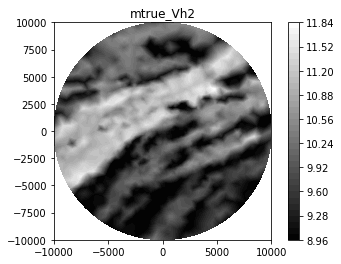

In [16]:
if mtrue_type == 'angel_peak' or mtrue_type == 'aces_building':
    image_dir = localpsf_root / 'localpsf'

    if mtrue_type == 'angel_peak':
#         image_file = image_dir / 'angel_peak_badlands_cropped9.png' # good
        image_file = image_dir / 'angel_peak_badlands_cropped7.png'
    else:
        image_file = image_dir / 'aces_building.png'
        
    mtrue_Vh2 = load_image_into_fenics(Vh2, image_file)
    minc = 9
    maxc = 12
    mtrue_Vh2_vec = mtrue_Vh2.vector()[:]
    mtrue_Vh2_vec *= 3
    mtrue_Vh2_vec += 9
    mtrue_Vh2.vector()[:] = mtrue_Vh2_vec
elif mtrue_type == 'sinusoid':
    mtrue_expr = dl.Expression(mtrue_string, element=Vh2.ufl_element(), m0=m0_constant_value, Radius=Radius)
    mtrue_Vh2 = dl.interpolate(mtrue_expr, Vh2)
else:
    raise RuntimeError('BAD mtrue_type')
        

mtrue_Vh3 = dl.Function(Vh3)
mtrue_Vh3.vector()[:] = Vh2_to_Vh3_numpy(mtrue_Vh2.vector()[:])

cm = dl.plot(mtrue_Vh2, cmap='gray')
plt.colorbar(cm)
plt.title('mtrue_Vh2')

In [17]:
SDAP.update_m(mtrue_Vh2.vector()[:])
SDAP.update_forward()
utrue.vector()[:] = SDAP.u.vector()[:].copy()

# Plots to make (2):
 - True velocity (arrows or not, up to you)
 - mtrue (basal sliding friction field)

# Add noise

In [18]:
utrue_vec = utrue.vector()[:]
noise_vec = noise_level * np.random.randn(Zh.dim()) * np.abs(utrue_vec)
uobs.vector()[:] = utrue_vec + noise_vec

In [19]:
def compute_misfit_datanorm():
    return np.sqrt(2.0 * SDAP.misfit())

noise_vec_petsc = dl.Function(Zh).vector()
noise_vec_petsc[:] = noise_vec
noise_datanorm = np.sqrt(data_inner_product(noise_vec_petsc, noise_vec_petsc))
print('noise_datanorm=', noise_datanorm)

noise_datanorm= 894.0322113006283


# Regularization

In [20]:
m_prior_mean_Vh2 = dl.Function(Vh2)
m_prior_mean_Vh2.vector()[:] = m0_constant_value * np.ones(Vh2.dim())
m_Vh2 = dl.Function(Vh2)
m_Vh2.vector()[:] = Wh_to_Vh2_numpy(m_Wh.vector()[:])

REG = BiLaplacianRegularization(gamma, prior_correlation_length, m_Vh2, m_prior_mean_Vh2)

/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/coo.py:431: SparseEfficiencyWarning: Constructing a DIA matrix with 1416 diagonals is inefficient
  warn("Constructing a DIA matrix with %d diagonals "


In [32]:
REG.update_gamma(gamma_morozov)
REG.update_correlation_length(prior_correlation_length)

sio.savemat('mass_matrix.mat', {'M' : REG.M_scipy})
np.savetxt('mass_matrix_diagonal.txt', REG.M_scipy.diagonal())
np.savetxt('mass_matrix_rowsums.txt', REG.M_scipy @ np.ones(Vh2.dim()))
sio.savemat('sqrtR_matrix.mat', {'sqrtR' : REG.Rsqrt_scipy})

/home/nick/anaconda3/envs/fenics4/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [22]:
Hdgn_array = np.zeros((Vh2.dim(), Vh2.dim()))
for ii in range(Vh2.dim()):
    print(Vh2.dim(), ii)
    ei = np.zeros(Vh2.dim())
    ei[ii] = 1.0
    Hdgn_array[:,ii] = SDAP.apply_gauss_newton_hessian(ei)

1416 0
1416 1
1416 2
1416 3
1416 4
1416 5
1416 6
1416 7
1416 8
1416 9
1416 10
1416 11
1416 12
1416 13
1416 14
1416 15
1416 16
1416 17
1416 18
1416 19
1416 20
1416 21
1416 22
1416 23
1416 24
1416 25
1416 26
1416 27
1416 28
1416 29
1416 30
1416 31
1416 32
1416 33
1416 34
1416 35
1416 36
1416 37
1416 38
1416 39
1416 40
1416 41
1416 42
1416 43
1416 44
1416 45
1416 46
1416 47
1416 48
1416 49
1416 50
1416 51
1416 52
1416 53
1416 54
1416 55
1416 56
1416 57
1416 58
1416 59
1416 60
1416 61
1416 62
1416 63
1416 64
1416 65
1416 66
1416 67
1416 68
1416 69
1416 70
1416 71
1416 72
1416 73
1416 74
1416 75
1416 76
1416 77
1416 78
1416 79
1416 80
1416 81
1416 82
1416 83
1416 84
1416 85
1416 86
1416 87
1416 88
1416 89
1416 90
1416 91
1416 92
1416 93
1416 94
1416 95
1416 96
1416 97
1416 98
1416 99
1416 100
1416 101
1416 102
1416 103
1416 104
1416 105
1416 106
1416 107
1416 108
1416 109
1416 110
1416 111
1416 112
1416 113
1416 114
1416 115
1416 116
1416 117
1416 118
1416 119
1416 120
1416 121
1416 122
141

1416 924
1416 925
1416 926
1416 927
1416 928
1416 929
1416 930
1416 931
1416 932
1416 933
1416 934
1416 935
1416 936
1416 937
1416 938
1416 939
1416 940
1416 941
1416 942
1416 943
1416 944
1416 945
1416 946
1416 947
1416 948
1416 949
1416 950
1416 951
1416 952
1416 953
1416 954
1416 955
1416 956
1416 957
1416 958
1416 959
1416 960
1416 961
1416 962
1416 963
1416 964
1416 965
1416 966
1416 967
1416 968
1416 969
1416 970
1416 971
1416 972
1416 973
1416 974
1416 975
1416 976
1416 977
1416 978
1416 979
1416 980
1416 981
1416 982
1416 983
1416 984
1416 985
1416 986
1416 987
1416 988
1416 989
1416 990
1416 991
1416 992
1416 993
1416 994
1416 995
1416 996
1416 997
1416 998
1416 999
1416 1000
1416 1001
1416 1002
1416 1003
1416 1004
1416 1005
1416 1006
1416 1007
1416 1008
1416 1009
1416 1010
1416 1011
1416 1012
1416 1013
1416 1014
1416 1015
1416 1016
1416 1017
1416 1018
1416 1019
1416 1020
1416 1021
1416 1022
1416 1023
1416 1024
1416 1025
1416 1026
1416 1027
1416 1028
1416 1029
1416 1030
1416 1

In [33]:
np.savetxt('Hdgn_array.txt', Hdgn_array, '%.2e') # save 2 digits of accuracy, i.e., 1.23e4
# np.savetxt('Hdgn_array.txt', Hdgn_array) # save 2 digits of accuracy, i.e., 1.23e4

# Load stuff

err_vertices_from_file= 0.0
err_cells_from_file= 0.0


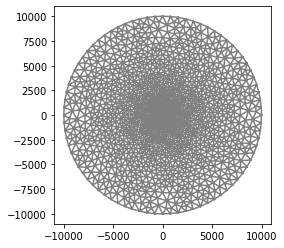

In [24]:
vertices_from_file = np.loadtxt('mesh_vertices.txt')
cells_from_file = np.loadtxt('mesh_cells.txt', dtype=int)

err_vertices_from_file = np.linalg.norm(vertices_from_file - basal_mesh2D.coordinates()) / np.linalg.norm(basal_mesh2D.coordinates())
print('err_vertices_from_file=', err_vertices_from_file)

err_cells_from_file = np.linalg.norm(cells_from_file - basal_mesh2D.cells()) / np.linalg.norm(cells_from_file)
print('err_cells_from_file=', err_cells_from_file)

mesh_from_file_meshio = meshio.Mesh(vertices_from_file, [("triangle", cells_from_file)])
mesh_from_file_meshio.write("mesh_from_file.xml")
mesh_from_file = dl.Mesh("mesh_from_file.xml")
dl.plot(mesh_from_file)

In [25]:
dof_coords_from_file = np.loadtxt('dof_coords.txt')

err_dof_coords_from_file = np.linalg.norm(dof_coords_from_file - Vh2.tabulate_dof_coordinates()) / np.linalg.norm(Vh2.tabulate_dof_coordinates())
print('err_dof_coords_from_file=', err_dof_coords_from_file)

err_dof_coords_from_file= 0.0


In [26]:
Hdgn_array_from_file = np.loadtxt('Hdgn_array.txt')

apply_Hdgn_from_file = lambda x: np.dot(Hdgn_array_from_file, x)

test_vec = np.random.randn(Hdgn_array_from_file.shape[1])
result1 = SDAP.apply_gauss_newton_hessian(test_vec)
result2 = apply_Hdgn_from_file(test_vec)
Hdgn_file_err = np.linalg.norm(result2 - result1) / np.linalg.norm(result2)
print('Hdgn_file_err=', Hdgn_file_err) # should be accurate to approx 1e-3 since 2 digits past decimal saved

Hdgn_file_err= 9.019065676873291e-11


In [27]:
sqrtR_from_file = sio.loadmat('sqrtR_matrix.mat')['sqrtR']

result1 = REG.Rsqrt_scipy * test_vec
result2 = sqrtR_from_file * test_vec
sqrtR_file_err = np.linalg.norm(result2 - result1) / np.linalg.norm(result2)
print('sqrtR_file_err=', sqrtR_file_err)

sqrtR_file_err= 0.0


In [28]:
M_from_file = sio.loadmat('mass_matrix.mat')['M']

result1 = REG.M_scipy * test_vec
result2 = M_from_file * test_vec
M_file_err = np.linalg.norm(result2 - result1) / np.linalg.norm(result2)
print('M_file_err=', sqrtR_file_err)

M_file_err= 0.0


In [29]:
vertex_in_dof = np.loadtxt('vertex_in_dof.txt', dtype=int)

err_vertex_in_dof = np.linalg.norm(pp_mesh2d - pp_Vh2[vertex_in_dof, :]) / np.linalg.norm(pp_mesh2d)
print('err_vertex_in_dof=', err_vertex_in_dof)

err_vertex_in_dof= 0.0


In [30]:
dof_in_vertex = np.loadtxt('dof_in_vertex.txt', dtype=int)

err_dof_in_vertex = np.linalg.norm(pp_Vh2 - pp_mesh2d[dof_in_vertex, :]) / np.linalg.norm(pp_Vh2)
print('err_dof_in_vertex=', err_dof_in_vertex)

err_dof_in_vertex= 0.0


In [31]:
diag_M_from_file = np.loadtxt('mass_matrix_diagonal.txt')

diag_M_from_file_err = np.linalg.norm(REG.M_scipy.diagonal() - diag_M_from_file) / np.linalg.norm(REG.M_scipy.diagonal())
print('diag_M_from_file_err=', diag_M_from_file_err)

diag_M_from_file_err= 0.0
